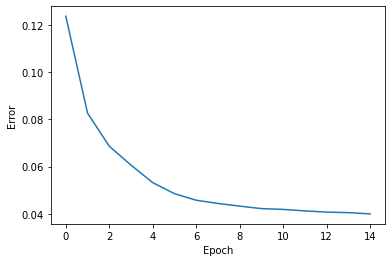

,MovieID,Title,Genres,List Index,Recommendation Score
2789,2858,American Beauty (1999),Comedy|Drama,2789,0.756496
2327,2396,Shakespeare in Love (1998),Comedy|Romance,2327,0.713125
2928,2997,Being John Malkovich (1999),Comedy,2928,0.573420
2530,2599,Election (1999),Comedy,2530,0.564360
3091,3160,Magnolia (1999),Drama,3091,0.544875


In [13]:
#Tensorflow library. Used to implement machine learning models

import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()
#Numpy contains helpful functions for efficient mathematical calculations
import numpy as np
#Dataframe manipulation library
import pandas as pd
#Graph plotting library
import matplotlib.pyplot as plt
%matplotlib inline

#Loading in the movies dataset
movies_df = pd.read_csv('movies.dat', sep='::', engine='python', header=None)
# movies_df.head()

#Loading in the ratings dataset
ratings_df = pd.read_csv('ratings.dat', sep='::', engine='python', header=None)
# ratings_df.head()

movies_df.columns = ['MovieID', 'Title', 'Genres']
ratings_df.columns = ['UserID', 'MovieID', 'Rating', 'Timestamp']
movies_df.head()
ratings_df.head()
movies_df['List Index'] = movies_df.index
movies_df.head()

#Merging movies_df with ratings_df by MovieID
merged_df = movies_df.merge(ratings_df, on='MovieID')
#Dropping unecessary columns
merged_df = merged_df.drop('Timestamp', axis=1).drop('Title', axis=1).drop('Genres', axis=1)
#Displaying the result
merged_df.head()

#Group up by UserID
userGroup = merged_df.groupby('UserID')
userGroup.first().head()

#Amount of users used for training
amountOfUsedUsers = 1000
#Creating the training list
trX = []
#For each user in the group
for userID, curUser in userGroup:
    #Create a temp that stores every movie's rating
    temp = [0]*len(movies_df)
    #For each movie in curUser's movie list
    for num, movie in curUser.iterrows():
        #Divide the rating by 5 and store it
        temp[movie['List Index']] = movie['Rating']/5.0
    #Now add the list of ratings into the training list
    trX.append(temp)
    #Check to see if we finished adding in the amount of users for training
    if amountOfUsedUsers == 0:
        break
    amountOfUsedUsers -= 1
hiddenUnits = 20    
visibleUnits = len(movies_df)
vb = tf.placeholder("float", [visibleUnits]) #Number of unique movies
hb = tf.placeholder("float", [hiddenUnits]) #Number of features we're going to learn
W = tf.placeholder("float", [visibleUnits, hiddenUnits])

#Phase 1: Input Processing
v0 = tf.placeholder("float", [None, visibleUnits])
_h0= tf.nn.sigmoid(tf.matmul(v0, W) + hb)
h0 = tf.nn.relu(tf.sign(_h0 - tf.random_uniform(tf.shape(_h0))))
#Phase 2: Reconstruction
_v1 = tf.nn.sigmoid(tf.matmul(h0, tf.transpose(W)) + vb) 
v1 = tf.nn.relu(tf.sign(_v1 - tf.random_uniform(tf.shape(_v1))))
h1 = tf.nn.sigmoid(tf.matmul(v1, W) + hb)

#Learning rate
alpha = 1.0
#Create the gradients
w_pos_grad = tf.matmul(tf.transpose(v0), h0)
w_neg_grad = tf.matmul(tf.transpose(v1), h1)
#Calculate the Contrastive Divergence to maximize
CD = (w_pos_grad - w_neg_grad) / tf.to_float(tf.shape(v0)[0])
#Create methods to update the weights and biases
update_w = W + alpha * CD
update_vb = vb + alpha * tf.reduce_mean(v0 - v1, 0)
update_hb = hb + alpha * tf.reduce_mean(h0 - h1, 0)

err = v0 - v1
err_sum = tf.reduce_mean(err * err)

#Current weight
cur_w = np.zeros([visibleUnits, hiddenUnits], np.float32)
#Current visible unit biases
cur_vb = np.zeros([visibleUnits], np.float32)
#Current hidden unit biases
cur_hb = np.zeros([hiddenUnits], np.float32)
#Previous weight
prv_w = np.zeros([visibleUnits, hiddenUnits], np.float32)
#Previous visible unit biases
prv_vb = np.zeros([visibleUnits], np.float32)
#Previous hidden unit biases
prv_hb = np.zeros([hiddenUnits], np.float32)
sess = tf.Session()
sess.run(tf.global_variables_initializer())

epochs = 15
batchsize = 100
errors = []
for i in range(epochs):
    for start, end in zip( range(0, len(trX), batchsize), range(batchsize, len(trX), batchsize)):
        batch = trX[start:end]
        cur_w = sess.run(update_w, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_vb = sess.run(update_vb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        cur_nb = sess.run(update_hb, feed_dict={v0: batch, W: prv_w, vb: prv_vb, hb: prv_hb})
        prv_w = cur_w
        prv_vb = cur_vb
        prv_hb = cur_nb
    errors.append(sess.run(err_sum, feed_dict={v0: trX, W: cur_w, vb: cur_vb, hb: cur_nb}))
plt.plot(errors)
plt.ylabel('Error')
plt.xlabel('Epoch')
plt.show()

#Selecting the input user
inputUser = [trX[101]]

#Feeding in the user and reconstructing the input
hh0 = tf.nn.sigmoid(tf.matmul(v0, W) + hb)
vv1 = tf.nn.sigmoid(tf.matmul(hh0, tf.transpose(W)) + vb)
feed = sess.run(hh0, feed_dict={ v0: inputUser, W: prv_w, hb: prv_hb})
rec = sess.run(vv1, feed_dict={ hh0: feed, W: prv_w, vb: prv_vb})

movies_df["Recommendation Score"] = rec[0]
movies_df.sort_values(["Recommendation Score"], ascending=False).head(5)